In [1]:
import requests

# Define the Lasair API endpoint and token
endpoint = "https://lasair-ztf.lsst.ac.uk/api/lightcurves/"
api_token = "6c29f0e52de2793c0afda7da204a90d08b0e4692"  # Replace with a valid API token

# Function to count points for each filter
def count_points(objectId, candidates):
    valid_candidates = [
        cand for cand in candidates
        if 'magpsf' in cand and 'magnr' in cand and 'isdiffpos' in cand
    ]
    if not valid_candidates:
        print(f"No valid light curve data for {objectId}")
        return {1: 0, 2: 0}  # Return 0 counts for both filters if no data

    fid = [cand['fid'] for cand in valid_candidates]
    count_filter_1 = fid.count(1)
    count_filter_2 = fid.count(2)

    return {1: count_filter_1, 2: count_filter_2}

# Function to fetch and count points for multiple ZTFIDs
def fetch_and_count_points(ztfids):
    for ztfid in ztfids:
        try:
            response = requests.post(
                endpoint,
                headers={"Authorization": f"Token {api_token}"},
                json={"objectIds": ztfid}
            )
            if response.status_code == 200:
                lightcurve_data = response.json()
                for obj in lightcurve_data:
                    counts = count_points(obj['objectId'], obj['candidates'])
                    print(f"Object ID: {obj['objectId']}")
                    print(f"Filter 1 (Green) Points: {counts[1]}")
                    print(f"Filter 2 (Red) Points: {counts[2]}")
            else:
                print(f"Error fetching light curve for {ztfid}: {response.status_code} - {response.text}")
        except Exception as e:
            print(f"Error processing {ztfid}: {e}")

# Example usage (replace with your actual ZTFIDs):
ztfids = ['ZTF17aabtvsy', 'ZTF17aabvong','ZTF17aacldgo']  # Example ZTF IDs
fetch_and_count_points(ztfids)

Error fetching light curve for ZTF17aabtvsy: 429 - {"message":"Request limit exceeded. Either wait an hour, or see API documentation to increase your limits."}
Error fetching light curve for ZTF17aabvong: 429 - {"message":"Request limit exceeded. Either wait an hour, or see API documentation to increase your limits."}
Error fetching light curve for ZTF17aacldgo: 429 - {"message":"Request limit exceeded. Either wait an hour, or see API documentation to increase your limits."}


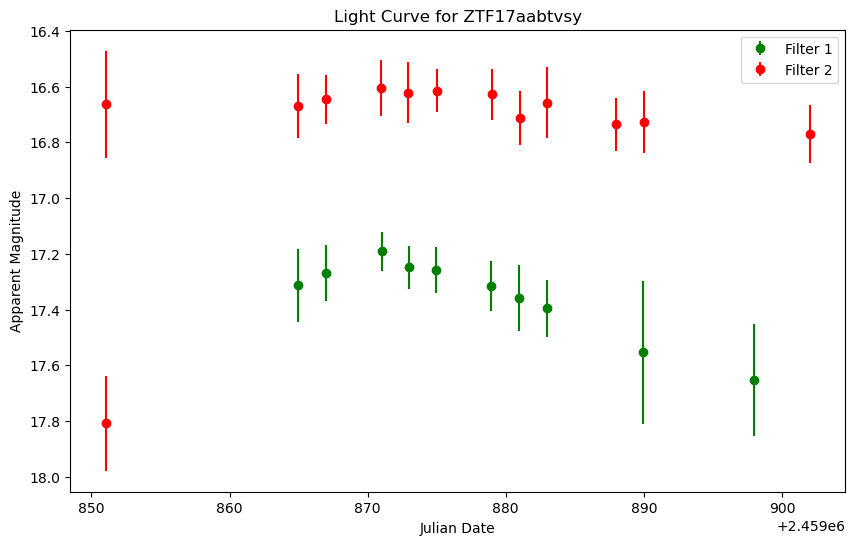

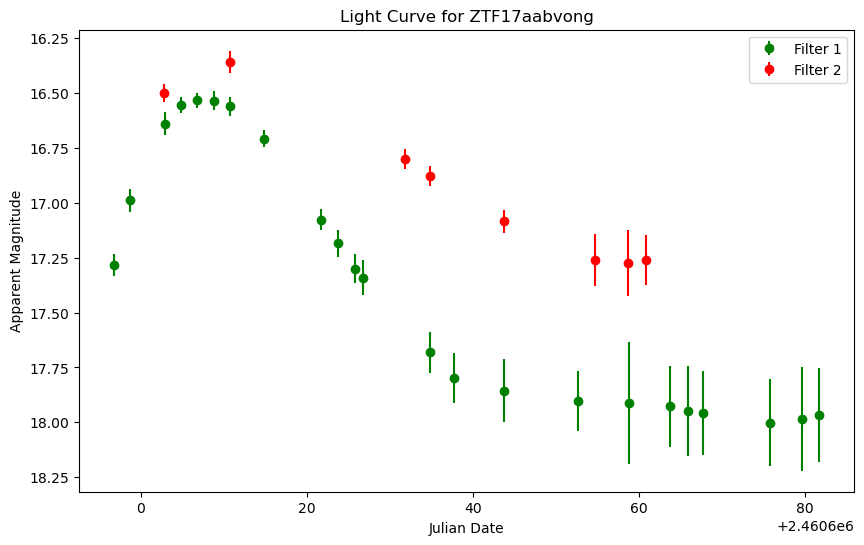

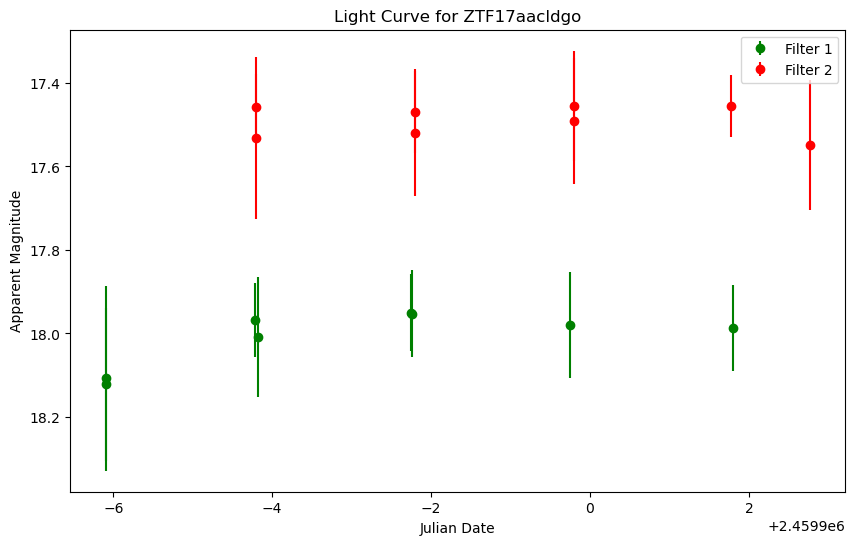

In [5]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file_path = '/home/jovyan/research/2.14.25/diego_data.csv'
data = pd.read_csv(file_path)

# Function to convert difference magnitudes to apparent magnitudes
def convert_to_apparent_magnitude(magpsf, magnr, isdiffpos):
    try:
        if isdiffpos == 't':
            return -2.5 * np.log10(10**(-0.4 * magpsf) + 10**(-0.4 * magnr))
        else:
            return -2.5 * np.log10(10**(-0.4 * magnr) - 10**(-0.4 * magpsf))
    except ValueError:
        return None

# Function to plot the light curve for an object
def plot_lightcurve(objectId, candidates):
    valid_candidates = [
        cand for cand in candidates
        if 'magpsf' in cand and 'magnr' in cand and 'isdiffpos' in cand
    ]
    if not valid_candidates:
        print(f"No valid light curve data for {objectId}")
        return

    jd = [cand['jd'] for cand in valid_candidates]
    mag = [
        convert_to_apparent_magnitude(cand['magpsf'], cand['magnr'], cand['isdiffpos'])
        for cand in valid_candidates
    ]
    sigmag = [cand['sigmapsf'] for cand in valid_candidates]
    fid = [cand['fid'] for cand in valid_candidates]

    plt.figure(figsize=(10, 6))
    colors = {1: 'green', 2: 'red'}

    for f in [1, 2]:  # Loop over filter IDs
        indices = [i for i in range(len(fid)) if fid[i] == f]
        if indices:
            plt.errorbar(
                [jd[i] for i in indices],
                [mag[i] for i in indices],
                yerr=[sigmag[i] for i in indices],
                fmt='o',
                color=colors[f],
                label=f'Filter {f}'
            )

    plt.gca().invert_yaxis()
    plt.title(f"Light Curve for {objectId}")
    plt.xlabel("Julian Date")
    plt.ylabel("Apparent Magnitude")
    plt.legend()
    plt.show()

# Function to fetch and plot light curves for multiple ZTFIDs
def fetch_and_plot_lightcurves(ztfids):
    for ztfid in ztfids:
        try:
            response = requests.post(
                endpoint,
                headers={"Authorization": f"Token {api_token}"},
                json={"objectIds": ztfid}
            )
            if response.status_code == 200:
                lightcurve_data = response.json()
                for obj in lightcurve_data:
                    plot_lightcurve(obj['objectId'], obj['candidates'])
            else:
                print(f"Error fetching light curve for {ztfid}: {response.status_code} - {response.text}")
        except Exception as e:
            print(f"Error processing {ztfid}: {e}")

# Extract ZTFIDs from the dataset
ztfids = data['ZTFID'].tolist()

# Call the function to fetch and plot light curves
fetch_and_plot_lightcurves(ztfids[:3])  # Limit to first 5 objects for demonstration
